# Lab 03 - Security Evaluations of Machine Learning Models

How to assess the security of a machine learning model? We saw previously that one epsilon is not enough.
Also, we have different attacks, how we characterize a model globally?

We introduce here the concept of *Security Evaluations*, which are used to better understand the impact of attacks against models.
First we create some data and two models that we want to compare.

In [30]:
try:
    import secmlt
except ImportError:
    %pip install git+https://github.com/pralab/secml-torch

In [31]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch
from secmlt.metrics.classification import Accuracy


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 16) # Hidden layer to hidden layer
        self.fc3 = torch.nn.Linear(16, 3)  # Hidden layer to output layer
        self.relu = torch.nn.ReLU()         # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        return x

class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = torch.nn.Linear(2, 6)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(6, 4)
        self.fc3 = torch.nn.Linear(4, 3)
        self.relu = torch.nn.ReLU()        

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        return x

centers = [(0, 1), (0, 0), (1, 1)]
cluster_std = 0.25
X_train, y_train = make_blobs(n_samples=500, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=999)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test, y_test = make_blobs(n_samples=100, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=999)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

model1 = Net()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=100)
secmlt_model = BasePytorchClassifier(model1, trainer=trainer)
secmlt_model.train(tr_dataloader)

model2 = Net2()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=100)
secmlt_model2 = BasePytorchClassifier(model2, trainer=trainer)
secmlt_model2.train(tr_dataloader)

accuracy1 = Accuracy()(secmlt_model, ts_dataloader)
accuracy2 = Accuracy()(secmlt_model2, ts_dataloader)
print("Test accuracy model 1: {:.2f}%".format(accuracy1 * 100))
print("Test accuracy model 2: {:.2f}%".format(accuracy2 * 100))

Test accuracy model 1: 98.00%
Test accuracy model 2: 98.00%


What can we say about the security of those models? The computation of security evaluations involve repeating attacks with increasing strength, hence it shuld approximate all the possible scenarios that can be envisioned once the models are deployed.

In [32]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

def security_evaluation(model, dataloader, epsilons):
    sec_eval_data = []
    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.L2,
            num_steps=50,
            step_size=0.01,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
    
        adv_dataloader = attack(model, dataloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
    return sec_eval_data

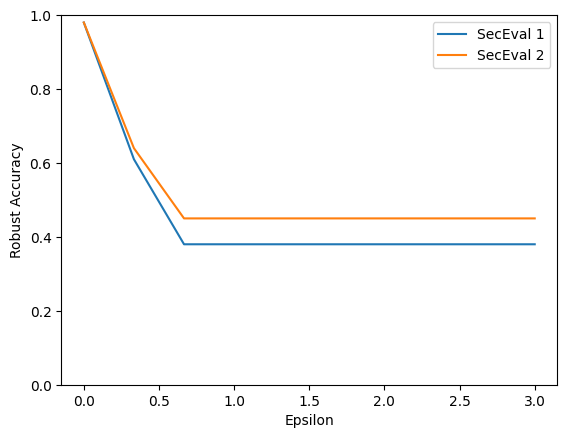

In [33]:
epsilons=np.linspace(0, 3, 10)
sec_eval_model1 = security_evaluation(secmlt_model, ts_dataloader, epsilons=np.linspace(0, 3, 10))
sec_eval_model2 = security_evaluation(secmlt_model2, ts_dataloader, epsilons=np.linspace(0, 3, 10))

plt.plot(epsilons, sec_eval_model1, label='SecEval 1')
plt.plot(epsilons, sec_eval_model2, label='SecEval 2')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Exercise 1
* What can you say about these evaluations? Are they ok? Is Model 2 more robust than Model 1, or viceversa? Try to change the parameters to better understand what is going on.
* Repeat the security evaluations, but change the norm (L1 or LINF). Are those evaluations comparable?